THIS IS WHERE THE NEW PROJECT STARTS!!!!

In [90]:
# this cell imports all the necessary packages/libraries related to the project
import numpy as np
import scipy 
import json
import pandas as pd
import gzip
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import model_selection  
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec

IMPORTING THE PRE-TRAINED WORD2VEC 

In [91]:
# model is a pretrained text file that is available for use in the Word2Vec library.
model =  word2vec.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

READING THE FILE

In [92]:
# Code taken from: http://jmcauley.ucsd.edu/data/amazon/index.html
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [93]:
# Code taken from: http://jmcauley.ucsd.edu/data/amazon/index.html
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield json.dumps(eval(l))

f = open("output.strict", 'w')
for l in parse("reviews_Kindle_Store_5.json.gz"):
    f.write(l + '\n')

In [94]:
# Code taken from: http://jmcauley.ucsd.edu/data/amazon/index.html
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Kindle_Store_5.json.gz')

CLEANING THE DATA

In [95]:
#df2=df
df2 = df[:1000]

In [96]:
del df2['reviewerID']
del df2['reviewerName']
del df2['summary']
del df2['helpful']
del df2['unixReviewTime']
del df2['reviewTime']

In [97]:
df2.head()

asin                                         reviewText  overall
0  B000F83SZQ  I enjoy vintage books and movies so I enjoyed ...      5.0
1  B000F83SZQ  This book is a reissue of an old one; the auth...      4.0
2  B000F83SZQ  This was a fairly interesting read.  It had ol...      4.0
3  B000F83SZQ  I'd never read any of the Amy Brewster mysteri...      5.0
4  B000F83SZQ  If you like period pieces - clothing, lingo, y...      4.0

In [98]:
df2.shape

(1000, 3)

In [99]:
df2= df2.set_index("asin")

In [100]:
df2_overall= pd.get_dummies(df2["overall"])

In [101]:
df2.head()

reviewText  overall
asin                                                                  
B000F83SZQ  I enjoy vintage books and movies so I enjoyed ...      5.0
B000F83SZQ  This book is a reissue of an old one; the auth...      4.0
B000F83SZQ  This was a fairly interesting read.  It had ol...      4.0
B000F83SZQ  I'd never read any of the Amy Brewster mysteri...      5.0
B000F83SZQ  If you like period pieces - clothing, lingo, y...      4.0

FEATURE SCALING (NORMALIZING)

In [102]:
#Creating dummies for the column: overall
df3= pd.concat([df2,df2_overall], axis=1)
df3.head()

reviewText  overall  1.0  \
asin                                                                          
B000F83SZQ  I enjoy vintage books and movies so I enjoyed ...      5.0    0   
B000F83SZQ  This book is a reissue of an old one; the auth...      4.0    0   
B000F83SZQ  This was a fairly interesting read.  It had ol...      4.0    0   
B000F83SZQ  I'd never read any of the Amy Brewster mysteri...      5.0    0   
B000F83SZQ  If you like period pieces - clothing, lingo, y...      4.0    0   

            2.0  3.0  4.0  5.0  
asin                            
B000F83SZQ    0    0    0    1  
B000F83SZQ    0    0    1    0  
B000F83SZQ    0    0    1    0  
B000F83SZQ    0    0    0    1  
B000F83SZQ    0    0    1    0

In [103]:
#creating a new column: score with values pre-set as 0
df3["score"]= [0]*len(df3)
df3.head()

reviewText  overall  1.0  \
asin                                                                          
B000F83SZQ  I enjoy vintage books and movies so I enjoyed ...      5.0    0   
B000F83SZQ  This book is a reissue of an old one; the auth...      4.0    0   
B000F83SZQ  This was a fairly interesting read.  It had ol...      4.0    0   
B000F83SZQ  I'd never read any of the Amy Brewster mysteri...      5.0    0   
B000F83SZQ  If you like period pieces - clothing, lingo, y...      4.0    0   

            2.0  3.0  4.0  5.0  score  
asin                                   
B000F83SZQ    0    0    0    1      0  
B000F83SZQ    0    0    1    0      0  
B000F83SZQ    0    0    1    0      0  
B000F83SZQ    0    0    0    1      0  
B000F83SZQ    0    0    1    0      0

In [104]:
#adding columns: 4.0 & 5.0. What we get is a column score that has value 1 
#when the overall (rating) is 4 or 5 and 0 otherwise

df3["score"]=df3[4.0]+df3[5.0]

In [105]:
df3

reviewText  overall  1.0  \
asin                                                                          
B000F83SZQ  I enjoy vintage books and movies so I enjoyed ...      5.0    0   
B000F83SZQ  This book is a reissue of an old one; the auth...      4.0    0   
B000F83SZQ  This was a fairly interesting read.  It had ol...      4.0    0   
B000F83SZQ  I'd never read any of the Amy Brewster mysteri...      5.0    0   
B000F83SZQ  If you like period pieces - clothing, lingo, y...      4.0    0   
B000F83SZQ  A beautiful in-depth character description mak...      4.0    0   
B000F83SZQ  I enjoyed this one tho I'm not sure why it's c...      4.0    0   
B000F83SZQ  Never heard of Amy Brewster. But I don't need ...      4.0    0   
B000FA64PA  Darth Maul working under cloak of darkness com...      5.0    0   
B000FA64PA  This is a short story focused on Darth Maul's ...      4.0    0   
B000FA64PA  I think I have this one in both book and audio...      5.0    0   
B000FA64PA  Title has nothing to do with the story.  I did...      4.0    0   
B000FA64PA  Well written. Interesting to see Sideous (thro...      3.0    0   
B000FA64PK  Troy Denning's novella Recovery was originally...      3.0    0   
B000FA64PK  I am not for sure on how much of a difference ...      5.0    0   
B000FA64PK  I really enjoyed the book. Had the normal back...      5.0    0   
B000FA64PK  Great read enjoyed every minute of it .  I thi...      5.0    0   
B000FA64PK  Another well written eBook by Troy Denning, bu...      3.0    0   
B000FA64PK  This one promises to be another good book. I h...      5.0    0   
B000FA64PK  I have a version of "Star by Star" that does n...      4.0    0   
B000FA64PK  Excellent! Very well written story, very excit...      5.0    0   
B000FA64QO  With Ylesia, a novella originally published in...      2.0    0   
B000FA64QO  Great book couldn't put it down.  The story ex...      5.0    0   
B000FA64QO  Most of the New Jedi Order books focus on the ...      4.0    0   
B000FA64QO  I was hoping to find this one in book form. Th...      5.0    0   
B000FA64QO  The events of "Ylesia" take place during "Dest...      3.0    0   
B000FBFMVG  Really shouldn't have Han Solo on the cover as...      5.0    0   
B000FBFMVG  Originally published as an e-book coinciding w...      3.0    0   
B000FBFMVG  This book was a good idea. I have always wante...      4.0    0   
B000FBFMVG  Great short story. It gives a little more insi...      5.0    0   
...                                                       ...      ...  ...   
B000X1XI32  This is the second book of Patrice Michelle  t...      5.0    0   
B000XZKZKM  Rafe and Emma forever, I luved this book so mu...      5.0    0   
B000XZKZKM  Eastern Texas, 1879At the age of five, Emma Ra...      5.0    0   
B000XZKZKM  I love the Leather and Lace series. They are r...      5.0    0   
B000XZKZKM  Emma Radcliff has loved Rafe Sinclair for most...      5.0    0   
B000XZKZKM  The story was pretty boring and I found myself...      1.0    1   
B000ZBTYXS                                            Love it      4.0    0   
B000ZBTYXS  Though a short story this was did in true Bian...      4.0    0   
B000ZBTYXS  I've read this at least three times now, and y...      5.0    0   
B000ZBTYXS  Not bad, but not memorable. A really good read...      3.0    0   
B000ZBTYXS  This is a charming anthology. Love Christmas s...      4.0    0   
B000ZBTYXS  As another reviewer wrote, Rebecca Winter's st...      1.0    1   
B000ZBTYXS  I enjoyed this Christmas romance.  I have it o...      4.0    0   
B000ZBTYYW  I liked the hero and the heroine. They were we...      4.0    0   
B000ZBTYYW  This book was just so sweet!  The H really ann...      4.0    0   
B000ZBTYYW  I really enjoyed this book. This book has all ...      5.0    0   
B000ZBTYYW  I found the emotions in this book to be very i...      5.0    0   
B000ZBTYYW  Great book. Second book of Jennie Lucas that I...      5.0    0   
B000ZC8DPM  Love Steph

In [106]:
#cleaning the dataset
del df3[1.0]
del df3[2.0]
del df3[3.0]
del df3[4.0]
del df3[5.0]


TOKENIZING AND SPLITTING

In [107]:
df3.reviewText = df3.reviewText.apply(lambda x: x.lower())

In [108]:
#Code taken from: https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [109]:
df3.reviewText = df3.reviewText.apply(remove_punctuations)


In [110]:
#converting reviews to lists (tokenizing and splitting)
tokenized = df3.reviewText.str.split().tolist()

WORD EMBEDDING AND SENTENCE EMBEDDING

In [112]:
semd=[]
for item in tokenized:
    wemd=np.zeros(300)
    for w in item:
         if w in model:
                wemd = np.add(model[w],wemd)
    semd.append(wemd)
print(semd)    
                    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [143]:
semd

[array([ 2.5923996 ,  1.38458061,  1.71408081,  4.30981445, -2.01069641,
        -0.58001709,  0.21110535, -2.00112915,  2.14941406,  3.74879456,
         0.09533691, -8.17590332, -0.76776123,  0.71554565, -4.39978027,
         2.5131073 ,  1.08029175,  4.14736938,  1.70949554, -3.0748291 ,
        -0.18060303,  2.56970215, -0.23503113, -1.51721954,  1.99395752,
        -1.43299389, -3.99273682,  2.64564514,  1.85403442, -0.21508789,
        -1.71366811,  0.18494415, -1.43780518,  0.20887375,  0.78448486,
         1.28684235, -0.05087852, -0.2026062 ,  0.83486938,  4.5125351 ,
         3.18500519, -2.65540314,  6.12475586, -1.02923584, -0.86251831,
         0.84889221, -0.01193237, -1.52170086,  0.89333916,  0.05629539,
        -0.43780518,  1.71206665,  0.5942688 ,  0.72181702,  0.58920288,
         2.92393494, -0.98783875, -0.90731812,  1.12467957, -2.92556763,
        -1.04049683,  4.05023193, -3.36220169, -4.23220825, -0.61051178,
         0.63264465, -2.85456085,  2.0746007 , -1.2

In [115]:
scorelist = df3["score"].tolist()

MACHINE LEARNING PART:
Applying different classification algorithms to the data:
1. Logistic Regression
2. support-vector machine with linear kernel
3. decision trees
4. random forest method


1. Logistic Regression

In [144]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(semd,scorelist, train_size=0.7)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [150]:
classifier_lr= linear_model.LogisticRegression()
classifier_lr.fit(X_train, y_train)
y_test_pred_lr= classifier.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [151]:
print(metrics.classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        70
           1       0.83      0.83      0.83       230

   micro avg       0.74      0.74      0.74       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.74      0.74      0.74       300



In [156]:
metrics.confusion_matrix(y_test, y_test_pred_lr)


array([[ 32,  38],
       [ 40, 190]])

In [157]:
metrics.accuracy_score(y_test, y_test_pred_lr, normalize=True, sample_weight=None)

0.74

2. SVM

In [158]:
classifier_svm= svm.SVC()
classifier_svm.fit(X_train, y_train)
y_test_pred_svm=classifier_svm.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [160]:
print(metrics.classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.77      1.00      0.87       230

   micro avg       0.77      0.77      0.77       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.59      0.77      0.67       300



In [162]:
metrics.confusion_matrix(y_test, y_test_pred_svm)

array([[  0,  70],
       [  0, 230]])

In [163]:
metrics.accuracy_score(y_test, y_test_pred_svm, normalize=True, sample_weight=None)

0.7666666666666667

3. Decision Trees

In [165]:
classifier_dt= tree.DecisionTreeClassifier()
classifier_dt.fit(X_train, y_train)
y_test_pred_dt= classifier.predict(X_test)

In [166]:
print(metrics.classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        70
           1       0.83      0.83      0.83       230

   micro avg       0.74      0.74      0.74       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.74      0.74      0.74       300



In [167]:
metrics.confusion_matrix(y_test, y_test_pred_dt)

array([[ 32,  38],
       [ 40, 190]])

In [168]:
metrics.accuracy_score(y_test, y_test_pred_dt, normalize=True, sample_weight=None)

0.74

4. Random Forest

In [169]:
classifier_rf= ensemble.RandomForestClassifier()
classifier_rf.fit(X_train, y_train)
y_test_pred_rf= classifier.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [170]:
print(metrics.classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        70
           1       0.83      0.83      0.83       230

   micro avg       0.74      0.74      0.74       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.74      0.74      0.74       300



In [171]:
metrics.confusion_matrix(y_test, y_test_pred_rf)

array([[ 32,  38],
       [ 40, 190]])

In [177]:
metrics.accuracy_score(y_test, y_test_pred_rf, normalize=True, sample_weight=None)

ValueError: Found input variables with inconsistent numbers of samples: [100, 300]

My attempt to plot different training and testing sample sizes and compare four classifiers. Not working, we can figure it out together. We need (at least) one plot like this

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explic

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explic

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will b

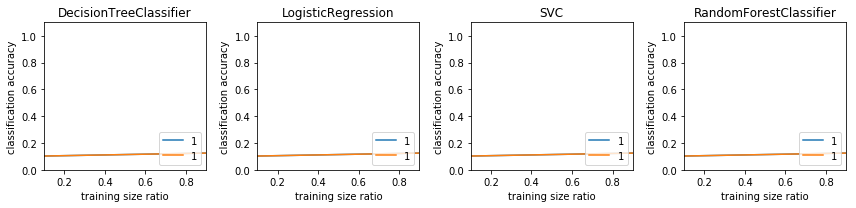

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
# create a numpy array with training size ratios, ranging from 10% to 90%
train_size_vec = np.linspace(0.1, 0.9, 30)

# create a list of classifiers
classifiers = [tree.DecisionTreeClassifier,
               linear_model.LogisticRegression,
               svm.SVC,
               ensemble.RandomForestClassifier
              ]

# create an array that stores the diagonals of the confusion matrix as a function of training size ratio
# and classifier
cm_diags = np.zeros((3, len(train_size_vec), len(classifiers)), dtype=float)

# loop over each training size ratio and classifier
for n, train_size in enumerate(train_size_vec):
    X_train, X_test, y_train, y_test = \
        model_selection.train_test_split(semd, scorelist, train_size=train_size)

    for m, Classifier in enumerate(classifiers): 
        classifier = Classifier()
        classifier.fit(X_train, y_train)
        y_test_pred = classifier.predict(X_test)
      #  cm_diags[:, n, m] = metrics.confusion_matrix(y_test, y_test_pred).diagonal()
       # cm_diags[:, n, m] /= np.bincount(y_test)
        
# plot accuracy as a function of training size ratio
fig, axes = plt.subplots(1, len(classifiers), figsize=(12, 3))

for m, Classifier in enumerate(classifiers): 
    axes[m].plot(train_size_vec, label=scorelist[1])
    axes[m].plot(train_size_vec, label=scorelist[0])
    axes[m].set_title(type(Classifier()).__name__)
    axes[m].set_ylim(0, 1.1)
    axes[m].set_xlim(0.1, 0.9)
    axes[m].set_ylabel("classification accuracy")
    axes[m].set_xlabel("training size ratio")
    axes[m].legend(loc=4)

fig.tight_layout()

Cross-Validation?